In [0]:
data_path = 'data/labeled_data.csv'

In [0]:
import pandas as pd
import numpy as np

np.random.seed(42)

In [0]:
df = pd.read_csv(data_path)

In [0]:
df.created_at = df.created_at.apply(pd.to_datetime)
df['time'] = df['created_at'].apply(lambda x: pd.Timestamp.round(x,'h'))

In [0]:

dataset = pd.DataFrame(df['ride_id'].groupby([df.time, df.pickup_district]).count())
dataset = dataset.rename(columns={"ride_id": "demand"}, index=str)
dataset = dataset.reset_index()

In [0]:
dataset_time_path = 'labeled_time_data.csv'
dataset.to_csv(dataset_time_path)
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 97064 entries, 0 to 97063
Data columns (total 3 columns):
time               97064 non-null object
pickup_district    97064 non-null object
demand             97064 non-null int64
dtypes: int64(1), object(2)
memory usage: 2.2+ MB


In [0]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, Dropout, BatchNormalization
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import math

Using TensorFlow backend.


In [0]:
dataset.head()

,time,pickup_district,demand
0,2018-08-21 00:00:00,871e76126ffffff,2
1,2018-08-21 00:00:00,871e76135ffffff,2
2,2018-08-21 00:00:00,871e76880ffffff,5
3,2018-08-21 00:00:00,871e76881ffffff,4
4,2018-08-21 00:00:00,871e76882ffffff,3


In [0]:
district = '871e7688affffff'
dataset_district = dataset[dataset['pickup_district']==district]
dataset_district = dataset_district.reset_index()

In [0]:
train_size = int(len(dataset_district) * 0.85)
test_size = len(dataset_district) - train_size
dataset_district.loc[:,'demand'] = dataset_district.loc[:,'demand'].apply(np.log)
min_ = dataset_district.loc[:,'demand'].min()
max_ = dataset_district.loc[:,'demand'].max()
train, test = dataset_district.loc[0:train_size,'demand'], dataset_district.loc[train_size:len(dataset_district),'demand']
print(len(train), len(test))

3461 611


In [0]:
def create_dataset(data, look_back=1):
  X = []
  y = []
  for i in range(look_back, len(data)):
      X.append(list(data.values[i-look_back:i]))
      y.append(data.values[i])
  
  return X, y
      
look_back = 24
X, y = create_dataset(train, look_back)
X = np.array(X)
y = np.array(y)
X = X.reshape(X.shape[0], X.shape[1], 1)

In [0]:
def create_model():
    model = Sequential()  

    model.add(LSTM(units=50, return_sequences=True, input_shape=(look_back, 1)))  
    model.add(Dropout(0.3))

    model.add(LSTM(units=50))  
    model.add(Dropout(0.3))  

    model.add(Dense(units = 1))  

    model.compile(optimizer = 'nadam', loss = 'mean_absolute_error')  
    return model

In [0]:
model = create_model()
model.fit(X, y, epochs=20, validation_split=0.2)

Train on 2749 samples, validate on 688 samples
Epoch 1/20
2749/2749 [==============================] - 11s 4ms/step - loss: 0.6669 - val_loss: 0.6621
Epoch 2/20
2749/2749 [==============================] - 10s 4ms/step - loss: 0.6096 - val_loss: 0.7398
Epoch 3/20
2749/2749 [==============================] - 10s 4ms/step - loss: 0.5760 - val_loss: 0.5702
Epoch 4/20
2749/2749 [==============================] - 10s 4ms/step - loss: 0.5538 - val_loss: 0.5532
Epoch 5/20
2749/2749 [==============================] - 10s 4ms/step - loss: 0.5532 - val_loss: 0.5278
Epoch 6/20
2749/2749 [==============================] - 10s 4ms/step - loss: 0.5446 - val_loss: 0.5444
Epoch 7/20
2749/2749 [==============================] - 10s 4ms/step - loss: 0.5384 - val_loss: 0.5154
Epoch 8/20
2749/2749 [==============================] - 10s 4ms/step - loss: 0.5335 - val_loss: 0.5875
Epoch 9/20
2749/2749 [==============================] - 10s 3ms/step - loss: 0.5256 - val_loss: 0.5300
Epoch 10/20
2749/2749 [===

In [0]:
X_test, y_test = create_dataset(test, look_back)
X_test = np.array(X)
y_test = np.array(y)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

y_pred = model.predict(X_test)

In [0]:
from sklearn.metrics import mean_absolute_error

mean_absolute_error(math.e ** y_pred, math.e ** y_test)

2.5741572818473077

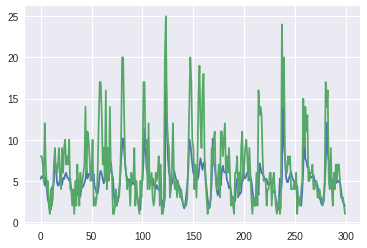

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline

    
plt.plot(math.e**y_pred[-300:].squeeze())
plt.plot(math.e**y_test[-300:].squeeze())

In [0]:
def predict_next_hours(model, data, hours):
    data_length = len(data)
    predicted = []
    for hour in range(hours):
      last_predicted = model.predict(data[-data_length:].reshape(1, -1, 1))
      predicted.append(last_predicted[0])
      data = np.append(data, last_predicted)
    return np.array(predicted)

In [0]:
predicted = predict_next_hours(model, X[-168], 168)

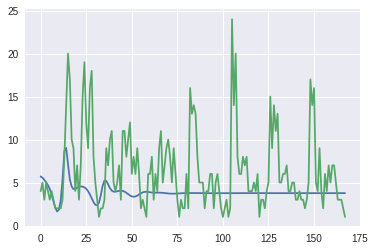

In [0]:
plt.plot(math.e ** predicted)
plt.plot(math.e ** y[-168:])